In [1]:
import pandas as pd
import boxball_loader as bbl

# How often does the road team win in extra innings?  Is the performance of road teams in 2020-21 significant?

In [2]:
gl = bbl.load_gamelogs(game_types=bbl.GameType.RS, seasons=bbl.Eras.Integration)
gl.shape

(143278, 164)

In [3]:
gl.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [4]:
gl['vis_win'] = gl['visitor_runs_scored'] > gl['home_runs_scored']
extras = gl.query('length_in_outs>54')
extras.shape


(13093, 165)

In [5]:
by_yr = extras.groupby(['yr', 'vis_win'])['date'].count().unstack()
by_yr

vis_win,False,True
yr,,
1947,40,53
1948,45,43
1949,60,57
1950,55,43
1951,65,53
...,...,...
2016,93,92
2017,96,86
2018,117,99


In [6]:
by_yr[by_yr[False]< by_yr[True]]

vis_win,False,True
yr,,
1947,40,53
1960,69,71
1964,67,80
1968,72,89
1976,96,106
1979,78,105
1983,93,97
1988,97,100
1992,101,109


In [7]:
by_yr.sum()

vis_win
False    6853
True     6240
dtype: int64

In [8]:
6204/(6204+6821)

0.47631477927063337

In [9]:
by_yr.mean()

vis_win
False    92.608108
True     84.324324
dtype: float64

## Quality of teams in extra inning games

Someone on reddit suggested that road teams in extras are, on average, above-average teams, because they've managed to offset HFA by tying the game.  Is this true

In [10]:
glt = bbl.load_gamelog_teams(game_types=bbl.GameType.RS, seasons=bbl.Eras.Integration)
glt.shape

(286556, 76)

In [11]:
glt.columns.values

array(['game_id', 'date', 'double_header', 'yr', 'game_type', 'park_id',
       'team', 'team_league', 'team_game_number', 'runs_scored',
       'line_score', 'ab', 'h', 'd', 't', 'hr', 'rbi', 'sh', 'sf', 'hbp',
       'bb', 'ibb', 'k', 'sb', 'cs', 'gdp', 'ci', 'lob', 'pitchers', 'er',
       'ter', 'wp', 'balks', 'po', 'a', 'e', 'passed', 'db', 'tp',
       'manager_id', 'manager_name', 'starting_pitcher_id',
       'starting_pitcher_name', 'batting_1_player_id', 'batting_1_name',
       'batting_1_position', 'batting_2_player_id', 'batting_2_name',
       'batting_2_position', 'batting_3_player_id', 'batting_3_name',
       'batting_3_position', 'batting_4_player_id', 'batting_4_name',
       'batting_4_position', 'batting_5_player_id', 'batting_5_name',
       'batting_5_position', 'batting_6_player_id', 'batting_6_name',
       'batting_6_position', 'batting_7_player_id', 'batting_7_name',
       'batting_7_position', 'batting_8_player_id', 'batting_8_name',
       'batting_8_posit

In [12]:
# Compute seasonal w-L records

def get_seasonal_wl(glt):
    wl_records = glt.groupby(['team', 'yr'])[['W', 'L']].sum()
    wl_records['pct'] = wl_records['W']/(wl_records['W']+wl_records['L'])
    return wl_records

get_seasonal_wl(glt)

W   L       pct
team yr                    
ANA  1997  84  78  0.518519
     1998  85  77  0.524691
     1999  70  92  0.432099
     2000  82  80  0.506173
     2001  75  87  0.462963
...        ..  ..       ...
WS2  1967  76  85  0.472050
     1968  65  96  0.403727
     1969  86  76  0.530864
     1970  70  92  0.432099
     1971  64  95  0.402516

[1820 rows x 3 columns]

In [13]:
def add_wpct_to_gms(extras, wl_records):
    e = extras[['yr', 'home_team', 'visiting_team', 'vis_win']]
    e = pd.merge(e, wl_records['pct'].reset_index(), left_on=['yr', 'home_team'], right_on=['yr', 'team']).rename(columns={'pct': 'home_wpct'})
    e = pd.merge(e, wl_records['pct'].reset_index(), left_on=['yr', 'visiting_team'], right_on=['yr', 'team']).rename(columns={'pct': 'vis_wpct'})
    e = e[['yr', 'home_team', 'visiting_team', 'vis_win', 'home_wpct', 'vis_wpct']]
    return e

e = add_wpct_to_gms(extras, get_seasonal_wl(glt))
e

,yr,home_team,visiting_team,vis_win,home_wpct,vis_wpct
0,1947,SLA,DET,False,0.383117,0.551948
1,1947,SLA,DET,False,0.383117,0.551948
2,1947,PHA,DET,True,0.506494,0.551948
3,1947,BOS,DET,True,0.538961,0.551948
4,1947,CHA,DET,True,0.454545,0.551948
...,...,...,...,...,...,...
13088,2020,BAL,BOS,False,0.416667,0.400000
13089,2020,ATL,BOS,False,0.583333,0.400000
13090,2020,CHN,PIT,False,0.566667,0.316667
13091,2020,MIN,CIN,True,0.600000,0.516667


<AxesSubplot:xlabel='yr'>

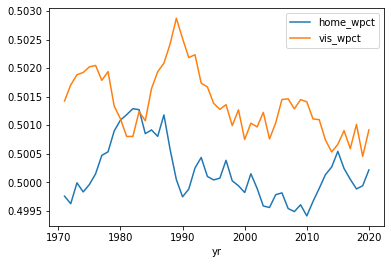

In [14]:
e.groupby('yr')[['home_wpct', 'vis_wpct']].mean().rolling(25).mean().plot()

In [15]:
# Well, I'll be.  Visiting teams are consistently better.  But the difference is small:
e.mean()

yr           1986.727259
vis_win         0.476591
home_wpct       0.500014
vis_wpct        0.501245
dtype: float64

In [16]:
# Now just look at road records of visiting teams

e = add_wpct_to_gms(extras, get_seasonal_wl(glt[glt['HA']=='A']))
e.mean()

yr           1986.727259
vis_win         0.476591
home_wpct       0.461969
vis_wpct        0.463166
dtype: float64